# Generate Lorenz attractor data


,X,Y,Z
0,0.000000,1.000000,1.050000
1,0.100000,0.990000,1.021996
2,0.189000,1.007078,0.995730
3,0.270808,1.048045,0.971077
4,0.348532,1.110761,0.948017
...,...,...,...
18247,-1.866625,-3.365286,19.796920
18248,-2.016491,-3.484754,19.331754
18249,-2.163317,-3.624700,18.886446
18250,-2.309455,-3.785608,18.461158


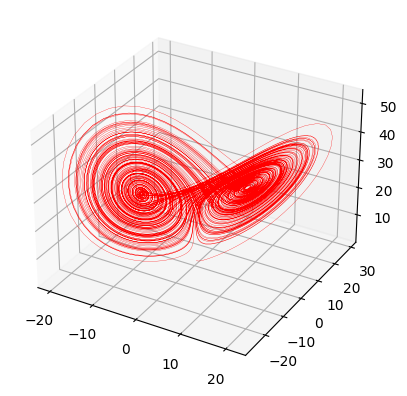

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def lorenz_attractor(x, y, z, s=10, r=28, b=2.667): #physic s,r,b are physics parameter https://en.wikipedia.org/wiki/Lorenz_system
    dx = s * (y - x)
    dy = x * (r - z) - y
    dz = x * y - b * z
    return dx, dy, dz

# Time parameters
dt = 0.01  # Time step, difference in time between one point and another
num_steps = 18251  # Number of time steps

# Initial conditions
x = np.ones(num_steps + 1)
y = np.ones(num_steps + 1)
z = np.ones(num_steps + 1)

# Set initial values
x[0], y[0], z[0] = 0.0, 1.0, 1.05

# Generate Lorenz attractor data
for i in range(num_steps):
    dx, dy, dz = lorenz_attractor(x[i], y[i], z[i])
    x[i + 1] = x[i] + dx * dt
    y[i + 1] = y[i] + dy * dt
    z[i + 1] = z[i] + dz * dt

# Create a dataframe with the Lorenz attractor data
df= pd.DataFrame({'X': x, 'Y': y, 'Z': z})


ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(df.X, df.Y, df.Z, color='red', linewidth=0.2 )
df

To help the model capture the local dynamics of the trajectory, I include first-order derivatives as additional input features. Each time step is therefore represented by six values: $x$, $y$, $z$, $\dot{x}$, $\dot{y}$, and $\dot{z}$.


In [14]:
dX_dt = np.gradient(df.X, dt)
dY_dt = np.gradient(df.Y, dt)
dZ_dt = np.gradient(df.Z, dt)

# Create a new dataframe with the Lorenz attractor variables and their derivatives
df= pd.DataFrame({
    'X': df.X,
    'Y': df.Y,
    'Z': df.Z,
    'dX_dt': dX_dt,
    'dY_dt': dY_dt,
    'dZ_dt': dZ_dt
})
df

,X,Y,Z,dX_dt,dY_dt,dZ_dt
0,0.000000,1.000000,1.050000,10.000000,-1.000000,-2.800350
1,0.100000,0.990000,1.021996,9.450000,0.353900,-2.713507
2,0.189000,1.007078,0.995730,8.540390,2.902265,-2.545969
3,0.270808,1.048045,0.971077,7.976577,5.184163,-2.385659
4,0.348532,1.110761,0.948017,7.697336,7.294653,-2.223634
...,...,...,...,...,...,...
18247,-1.866625,-3.365286,19.796920,-15.266930,-10.943827,-47.510113
18248,-2.016491,-3.484754,19.331754,-14.834620,-12.970734,-45.523738
18249,-2.163317,-3.624700,18.886446,-14.648231,-15.042745,-43.529795
18250,-2.309455,-3.785608,18.461158,-14.687683,-17.167364,-41.510995


# Build DataLoaders


Three utilities are used to prepare the training data:

1) **`normalize_data`** scales each feature to a fixed range (either `[0, 1]` or `[-1, 1]`). Recurrent models (including LSTMs) are sensitive to feature scale because their gating mechanisms rely heavily on `tanh`/`sigmoid` activations; unscaled inputs can lead to saturated activations and unstable gradients. In practice, `[-1, 1]` tends to work slightly better here.

2) **`create_intervals`** builds a sliding-window dataset. With `seq_length=366` and `predict_days=1`, it returns:
- an input sequence of length `365` (`seq_length - predict_days`)
- a target consisting of the next time step (`1` step)

3) **`StockDataset`** is a lightweight `torch.utils.data.Dataset` wrapper that converts the NumPy arrays into tensors so they can be consumed by a PyTorch `DataLoader`.


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler


def create_intervals(data, seq_length=366, predict_days=1):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        input_seq = seq[: seq_length - predict_days]
        target_seq = seq[seq_length - predict_days:]
        
        sequences.append(input_seq)
        targets.append(target_seq)  # Assuming 'Close' is column 3
    
    return np.array(sequences), np.array(targets)

#Custom Dataset class
class StockDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        return torch.tensor(self.sequences[index], dtype=torch.float32), torch.tensor(self.targets[index], dtype=torch.float32)



In [16]:
# Normalize the data
scaled_data, scaler = normalize_data(df.values)

# Create intervals of 90 days
sequences, targets = create_intervals(scaled_data)



In [17]:
#  Train-Test Split
train_size = int(len(sequences) * 0.8) #outputs a single int 
test_size = len(sequences) - train_size
#part of the training set, each train sequence of 200 is matched with a target of next 160 days
train_sequences = sequences[:train_size]
train_targets = targets[:train_size]
#part of the test set, each train sequence of 200 is matched with a target of next 160 days
test_sequences = sequences[train_size:]
test_targets = targets[train_size:]


In [18]:

# Step 5: Create DataLoaders
train_dataset = StockDataset(train_sequences, train_targets)
test_dataset = StockDataset(test_sequences, test_targets)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Each batch produced by the DataLoaders contains:

- `inputs` with shape **`[128, 365, 6]`** = `[batch, time, features]`
- `targets` with shape **`[128, 1, 6]`** = `[batch, horizon, features]`


In [19]:
for x,i in train_loader:
    print (x.shape, i.shape)

torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])
torch.Size([128, 365, 6]) torch.Size([128, 1, 6])


# Define the model


The model consists of stacked LSTM layers followed by a small feed-forward head:

1) **LSTM backbone.** In the forward pass, the hidden state and cell state are initialized and passed together with the input sequence. From the LSTM outputs, we use the final hidden state of the top LSTM layer (`h_n[-1]`), which summarizes the entire input window.

2) **MLP prediction head.** The final hidden state is mapped to the 6-dimensional output (next-step $x, y, z, \dot{x}, \dot{y}, \dot{z}$) via several fully connected layers. Empirically, a shallow head underfits, while adding many more layers provides limited benefit.

3) **Dropout and activations.** Dropout is used for regularization and to improve stability during training. The nonlinearity is **SELU**, which worked comparably to `tanh` in this setting; `ReLU` tended to produce overly piecewise predictions.


In [20]:
for input, targets in train_loader:
    print (input[:, -1, :3].shape)

torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([128, 3])
torch.Size([1

In [21]:
"""import torch
import torch.nn as nn

class stocklstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length=366, predict_days=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.predict_days = predict_days * 6

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=0.4) #lstm

        self.fc_1 =  nn.Linear(hidden_size, hidden_size*2) #fully connected 1
        self.fc_2 =  nn.Linear(hidden_size*2, hidden_size*4) #fully connected 1
        self.fc_3 =  nn.Linear(hidden_size*4, hidden_size*2) #fully connected 1
        self.fc_4 =  nn.Linear(hidden_size*2, hidden_size) #fully connected 1
        # Fully connected layers to map hidden state to output predictions
        self.fc_out = nn.Linear(hidden_size, self.predict_days)


        self.dropout= nn.Dropout(p=0.5)
        self.selu = nn.SELU()

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        output, (h_n, c_n) = self.lstm(x, (h0, c0))  # LSTM outputs all hidden states
        out = h_n[-1]  # Take the output of the last time step,  the last h_n of last layer, size [128,128]


        out = self.selu(self.fc_1(out))  # Activation after first FC
        out = self.dropout(out)

        out = self.selu(self.fc_2(out))  # Activation after first FC
        out = self.dropout(out)

        out = self.selu(self.fc_3(out))  # Activation after first FC
        out = self.dropout(out)
        
        out = self.selu(self.fc_4(out))  # Activation after first FC
        out = self.dropout(out)

        out = self.fc_out(out)  # Final output layer without activation (for regression)
        #print (out.shape)
        #out = out.reshape(-1,self.predict_days / 3,3)
        return out


"""

'import torch\nimport torch.nn as nn\n\nclass stocklstm(nn.Module):\n    def __init__(self, input_size, hidden_size, num_layers, seq_length=366, predict_days=1):\n        super().__init__()\n        self.num_layers = num_layers\n        self.hidden_size = hidden_size\n        self.seq_length = seq_length\n        self.predict_days = predict_days * 6\n\n        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,\n                          num_layers=num_layers, batch_first=True, dropout=0.4) #lstm\n\n        self.fc_1 =  nn.Linear(hidden_size, hidden_size*2) #fully connected 1\n        self.fc_2 =  nn.Linear(hidden_size*2, hidden_size*4) #fully connected 1\n        self.fc_3 =  nn.Linear(hidden_size*4, hidden_size*2) #fully connected 1\n        self.fc_4 =  nn.Linear(hidden_size*2, hidden_size) #fully connected 1\n        # Fully connected layers to map hidden state to output predictions\n        self.fc_out = nn.Linear(hidden_size, self.predict_days)\n\n\n        self.d

In [55]:
import torch
import torch.nn as nn

class lorentzlstm(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length=366, predict_days=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.predict_days = predict_days * 6

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=0.4) #lstm

        self.fc_1 =  nn.Linear(hidden_size, hidden_size*2) #fully connected 1
        self.fc_2 =  nn.Linear(hidden_size*2, hidden_size*4) #fully connected 1
        self.fc_3 =  nn.Linear(hidden_size*4, hidden_size*2) #fully connected 1
        self.fc_4 =  nn.Linear(hidden_size*2, hidden_size) #fully connected 1
        # Fully connected layers to map hidden state to output predictions
        self.fc_out = nn.Linear(hidden_size, self.predict_days)



        self.dropout= nn.Dropout(p=0.5)
        self.selu = nn.SELU()

    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        output, (h_n, c_n) = self.lstm(x, (h0, c0))  # LSTM outputs all hidden states
        out = h_n[-1]  # Take the output of the last time step,  the last h_n of last layer, size [128,128]


        out = self.dropout(self.fc_1(out))  # Activation after first FC
        out = self.selu(out)

        out = self.dropout(self.fc_2(out))  # Activation after first FC
        out = self.selu(out)

        out = self.dropout(self.fc_3(out))  # Activation after first FC
        out = self.selu(out)
        
        out = self.dropout(self.fc_4(out))  # Activation after first FC
        out = self.selu(out)

        out = self.fc_out(out)  # Final output layer without activation (for regression)
        #print (out.shape)
        #out = out.reshape(-1,self.predict_days / 3,3)

        """
        gradient = (out[:, :3] - x[:, -1, :3]) /dt
            

        out = torch.concat((out[:, :3],gradient), 1)
        """
        
        return out




Training configuration notes:

1) **Model size.** The model is instantiated with `input_size=6`, `hidden_size=128`, and `num_layers=9`. While many references suggest that 1–3 LSTM layers are often sufficient, increasing depth improved performance for this specific task (likely because the dynamics are highly nonlinear). Further improvements may also come from alternatives such as larger hidden size, layer normalization, or architectural changes rather than adding more layers.

2) **Loss function.** Both `MSELoss` and `HuberLoss` were tested. Since this dataset is deterministic and essentially noise-free, `MSELoss` is a natural choice; in practice the two behaved similarly.

3) **Optimizer.** Several optimizers were evaluated (AdamW, Adam, Adagrad, SGD, RMSprop). RMSprop performed best in this notebook with `lr=1e-4` and `momentum=0.9` .


In [56]:
device = "cuda"
lstm = lorentzlstm(6,128,9).to("cuda")
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(lstm.parameters(), lr=0.0001, momentum=0.9)


In [24]:
lstm

lorenzlstm(
  (lstm): LSTM(6, 128, num_layers=9, batch_first=True, dropout=0.4)
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=256, bias=True)
  (fc_4): Linear(in_features=256, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (selu): SELU()
)

In [54]:
for input, targets in train_loader:
    input= input.to(device)
    print(lstm(input))
    break

tensor([[ 4.5706e-01,  5.9219e-01, -3.2413e-01,  7.2902e-02, -3.9372e-01,
          1.0854e+01],
        [-2.3636e-01, -2.9977e-01, -7.2791e-01, -1.3338e+01, -1.5106e+01,
          1.2457e+01],
        [-6.9575e-01, -3.4633e-01,  3.1442e-01, -8.4478e+00, -2.6035e+00,
         -1.3429e-02],
        [-2.6344e-01, -2.0738e-01, -1.5209e-01, -3.0899e+00, -1.3704e+00,
          5.3749e+00],
        [ 5.9867e-02,  1.0903e-01, -5.4822e-01, -4.9003e+00, -3.1270e+00,
          2.1530e+00],
        [-4.2312e-01, -2.9975e-01, -5.9720e-04,  4.4988e+00,  6.7966e+00,
         -9.9345e-01],
        [ 1.1748e-01,  9.9251e-02, -2.4118e-01, -3.7457e+00,  1.6559e-01,
         -2.4794e+00],
        [-5.6432e-01, -5.6410e-01, -1.0804e-03, -3.1674e+00, -6.1743e+00,
          4.4929e+00],
        [ 1.3977e-01,  1.7970e-01, -7.3551e-01, -5.9584e+00, -9.7566e+00,
         -8.3475e+00],
        [ 2.7093e-01,  2.0480e-01, -1.2517e-01, -4.6318e+00, -6.9207e+00,
          3.9184e+00],
        [ 5.8506e-02,  2.4120e

In [26]:
from torchviz import make_dot

x = torch.randn(1, 365 , 6).to(device)  # Replace with appropriate input size
output = lstm(x)

# Visualize the model
dot = make_dot(output, params=dict(lstm.named_parameters()))

dot.render("lorentz_attractor_model_architecture", format="svg") 


'lorentz_attractor_model_architecture.svg'

# Train the model


In [58]:
# Training loop
clip_value = 0.8
num_epochs = 20
for epoch in range(num_epochs):
    lstm.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = lstm(inputs)
        #print (outputs.shape, targets.squeeze().shape )
        loss = criterion(outputs, targets.squeeze())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_value_(lstm.parameters(), clip_value)
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average train loss for this epoch
    train_loss /= len(train_loader)
    
    # Validation step (on test set)
    lstm.eval()
    test_loss = 0
    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs =lstm(inputs)
            loss = criterion(outputs, targets.squeeze())
            test_loss += loss.item()
    
    # Average test loss for this epoch
    test_loss /= len(test_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/20], Train Loss: 33.2310, Test Loss: 5.9038
Epoch [2/20], Train Loss: 30.7409, Test Loss: 1.3986
Epoch [3/20], Train Loss: 29.4363, Test Loss: 2.3024
Epoch [4/20], Train Loss: 28.6587, Test Loss: 0.8585
Epoch [5/20], Train Loss: 28.5013, Test Loss: 0.9563
Epoch [6/20], Train Loss: 28.9173, Test Loss: 1.8390
Epoch [7/20], Train Loss: 28.6386, Test Loss: 1.7320
Epoch [8/20], Train Loss: 27.7666, Test Loss: 3.1902
Epoch [9/20], Train Loss: 28.1951, Test Loss: 3.6165
Epoch [10/20], Train Loss: 28.2287, Test Loss: 1.5740
Epoch [11/20], Train Loss: 27.6656, Test Loss: 1.2109
Epoch [12/20], Train Loss: 27.6725, Test Loss: 1.8751
Epoch [13/20], Train Loss: 27.4233, Test Loss: 1.7084
Epoch [14/20], Train Loss: 26.8021, Test Loss: 1.8940
Epoch [15/20], Train Loss: 26.6064, Test Loss: 2.1320
Epoch [16/20], Train Loss: 26.6971, Test Loss: 3.1355
Epoch [17/20], Train Loss: 26.4950, Test Loss: 2.1259
Epoch [18/20], Train Loss: 26.3924, Test Loss: 1.9396
Epoch [19/20], Train Loss: 26.5422, T

KeyboardInterrupt: 

In [ ]:
"""# Training loop
clip_value = 0.5
num_epochs = 20
for epoch in range(num_epochs):
    lstm.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass
        output = lstm(inputs)

        dx_dt = (output[2:, 0] - output[:-2, 0]) / (2 * dt)
        dy_dt = (output[2:, 1] - output[:-2, 1]) / (2 * dt)
        dz_dt = (output[2:, 2] - output[:-2, 2]) / (2 * dt)

        true_dx_dt = targets.squeeze()[1:-1,3]
        true_dy_dt = targets.squeeze()[1:-1,4]
        true_dz_dt = targets.squeeze()[1:-1,5]


        loss_positions = criterion(output, targets.squeeze()[:,:3])  # Loss between predicted and true x, y, z
        loss_dx = criterion(dx_dt, true_dx_dt)/3
        loss_dy = criterion(dy_dt, true_dy_dt)/3
        loss_dz = criterion(dz_dt, true_dz_dt)/3
        
        # Total loss: combining position and derivative losses
        loss = loss_positions + loss_dx + loss_dy + loss_dz

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()

        nn.utils.clip_grad_value_(lstm.parameters(), clip_value)
        optimizer.step()
        
        train_loss += loss.item()
    
    # Average train loss for this epoch
    train_loss /= len(train_loader)
    


    # Validation step (on test set)
    lstm.eval()
    test_loss = 0
    with torch.inference_mode():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            output =lstm(inputs)
            loss = criterion(output, targets.squeeze()[:,:3])
            test_loss += loss.item()
    
    # Average test loss for this epoch
    test_loss /= len(test_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
"""

# Visualize results


The final section visualizes an autoregressive rollout on a selected test sequence.

- `plot_index` selects which test sequence to visualize.
- `predict_amount` controls how many future time steps are generated.


In [58]:
plot_index=200
predict_amount=365

In [59]:
A = torch.tensor(test_sequences[plot_index], dtype=torch.float32).unsqueeze(0).to(device)
A.shape

torch.Size([1, 365, 6])

Autoregressive inference is performed by repeatedly predicting the next step, appending it to the current sequence, and predicting again. As the horizon increases, small errors compound, so long rollouts are expected to become progressively less accurate.


In [60]:
B=A
lstm.eval()
with torch.inference_mode():
    for i in range(predict_amount):
        C = lstm(B).unsqueeze(0)
        B = torch.concat ((B, C), 1)
print (B.shape)        
A = A.cpu().numpy() 
B = B.cpu().numpy()

torch.Size([1, 730, 6])


In [61]:
test_sequences.shape

(3578, 365, 6)

In [62]:
test_targets[plot_index:plot_index + predict_amount, 0, 0].shape

(365,)

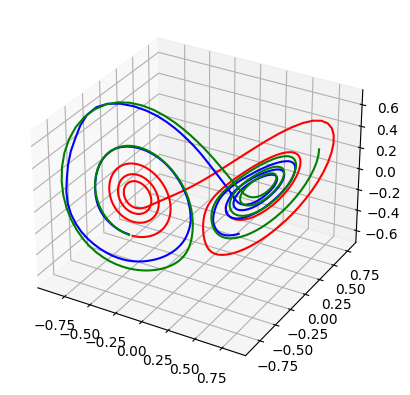

In [63]:
#test_sequences is the input sequence
#B in input sequence + predicted things (take the last predict_amount)
#targets sequence is the targets, take the first predict_amount starting from plot index
ax = plt.axes(projection='3d')
#ax.view_init(0,90) #you can use this to move the view
ax.plot3D(test_sequences[plot_index, :, 0], test_sequences[plot_index, :, 1], test_sequences[plot_index, :, 2], 'red')
ax.plot3D(B[0, -predict_amount:, 0], B[0, -predict_amount:, 1], B[0, -predict_amount:, 2], 'blue')
ax.plot3D(test_targets[plot_index:plot_index + predict_amount, 0, 0], test_targets[plot_index:plot_index + predict_amount, 0, 1], test_targets[plot_index:plot_index + predict_amount, 0, 2], 'green')


In [57]:
#torch.save(lstm.state_dict(), "C:/Users/repea/Downloads/lorenz.pth")
#lstm.load_state_dict(torch.load("C:/Users/repea/Downloads/lorenz.pth"))

<All keys matched successfully>